# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'xDZqAGaf8GtFxFEcMGMy'

In [3]:
# Importing the Germany Unemployment Rate, % of Total Labor Force variable.

data = quandl.get('RATEINF/CPI_EUR')

In [4]:
data.head(5)

,Value
Date,
1990-01-31,69.46
1990-02-28,69.71
1990-03-31,69.88
1990-04-30,70.14
1990-05-31,70.30


In [5]:
data.shape

(402, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

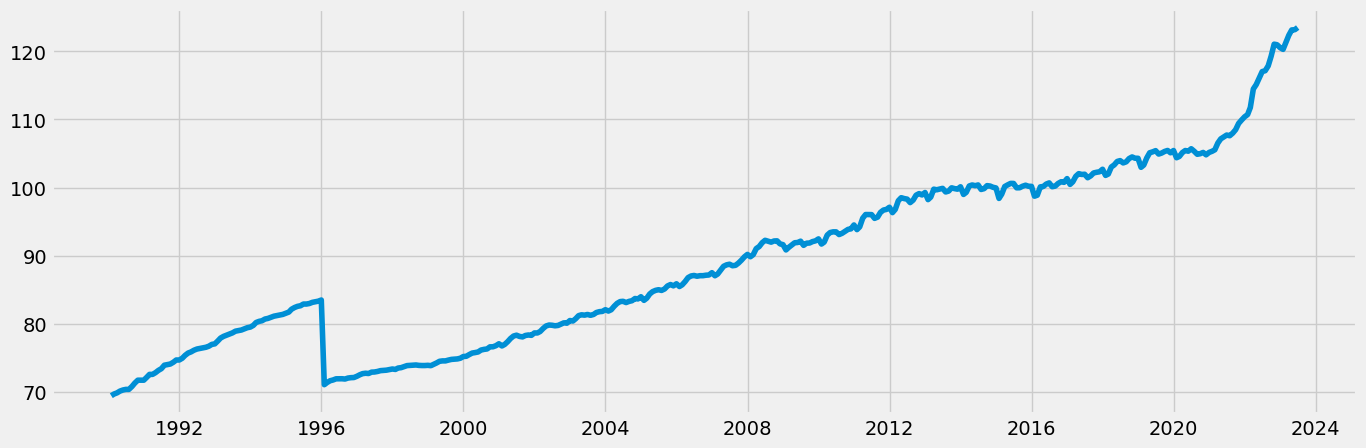

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

#### Observation: Over the years, the inflation rate had a slump in 1996 and has risen constantly since then. 

### 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1990-01-31,69.46
1,1990-02-28,69.71
2,1990-03-31,69.88
3,1990-04-30,70.14
4,1990-05-31,70.30


In [50]:
# Even if the inflation rate does not really have anything to do with my main project, I would still be interested in the period 2015 - 2023. For example, we also include GDP per capita in the main project and it would be interesting to see whether the GDP per capita score has changed with an increasing inflation rate and thus the happiness score. 
data_sub = data_2.loc[(data_2['Date'] >= '2015-01-01') & (data_2['Date'] < '2023-04-01')]

In [13]:
data_sub.shape

(99, 2)

In [14]:
data_sub.head()

,Date,Value
300,2015-01-31,98.40
301,2015-02-28,99.03
302,2015-03-31,100.15
303,2015-04-30,100.39
304,2015-05-31,100.61


In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2015-01-31,98.40
2015-02-28,99.03
2015-03-31,100.15
2015-04-30,100.39
2015-05-31,100.61


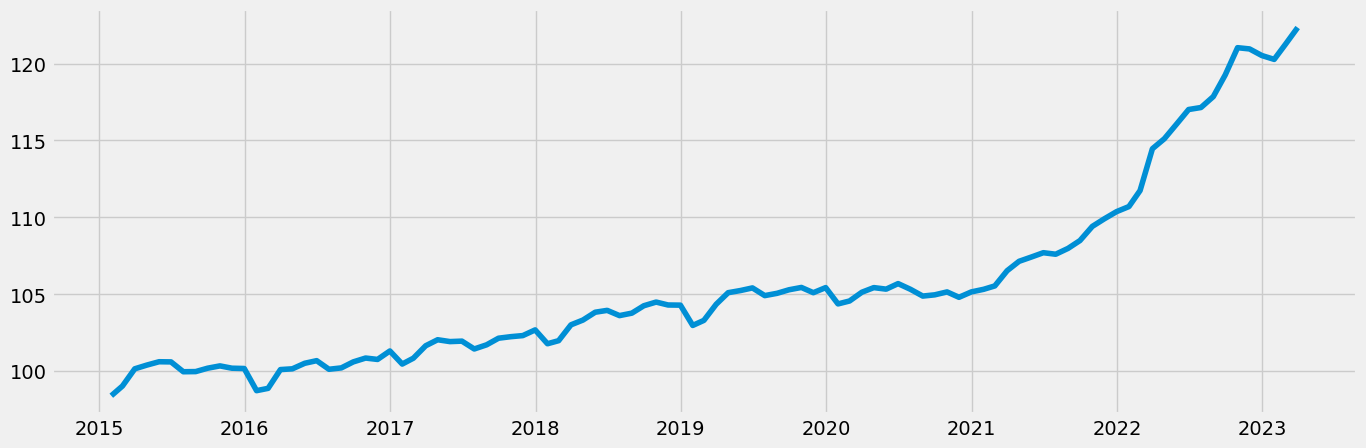

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

#### Observation: Since 2015 the  inflation rate has risen constantly.

In [17]:
# Check for missing values
data_sub.isnull().sum() 

Value    0
dtype: int64

In [18]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# 7 dups!

7

In [19]:
data_sub_1 = data_sub.drop_duplicates()

In [20]:
# Check for duplicates

dups = data_sub_1.duplicated()
dups.sum()

# no dups!


0

### Note: 
Even if 7 duplicates are displayed, I will not remove them for the upcoming calculations. 
The reason for this is that I get an error message for the upcoming calculations when I remove the duplicates. 

The following error message: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None phython

### 3. Time-series analysis: decomposition

In [22]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [23]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

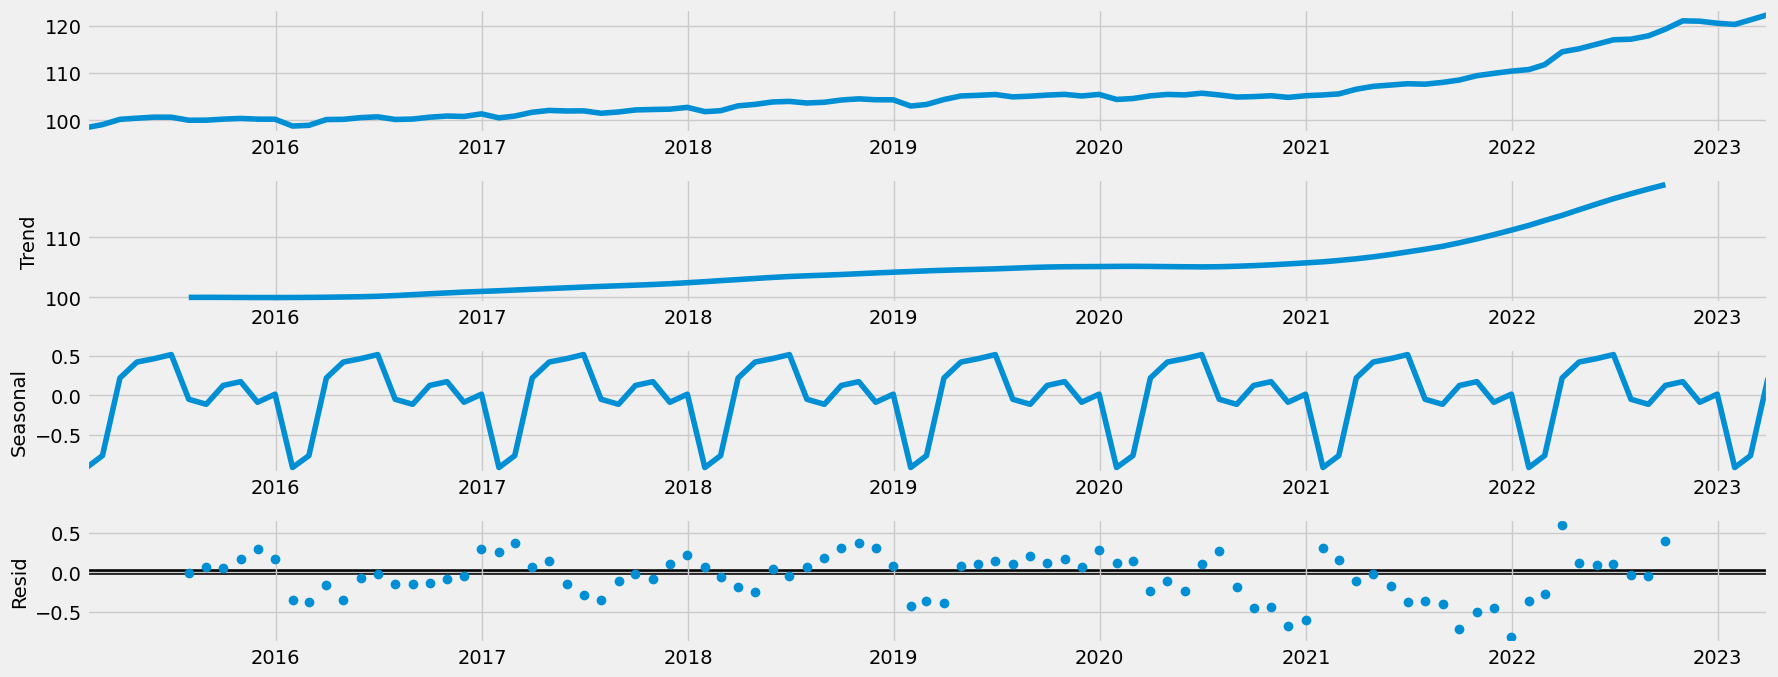

In [24]:
# Plot the separate components

decomposition.plot()
plt.show()

### Observation:
The trend in the chart above gradually rises in a linear fashion after 2019 and especiallx after 2022. That is likedly due to the aftereffects of the corona crisis and the russian and ukraine war that has an impact on a lot of consumer goods. The overall trend continues to rise all the way until the present year. This can be called a dominant trend.

We can also see seasonality as the inflationsrate falls with the beginnig of a new year and rises almost immediately.

There also seems to be some unexplained noise.


### 4. Testing for stationarity

In [34]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.422728
p-value                         0.906234
Number of Lags Used            12.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


### Observation

My rest statistic (0,422) is larger than critical value (-2,89) therefore I can’t reject null hypothesis.
That means I sem to have a unit root, non stationary data and cannot proceed with the forecast.

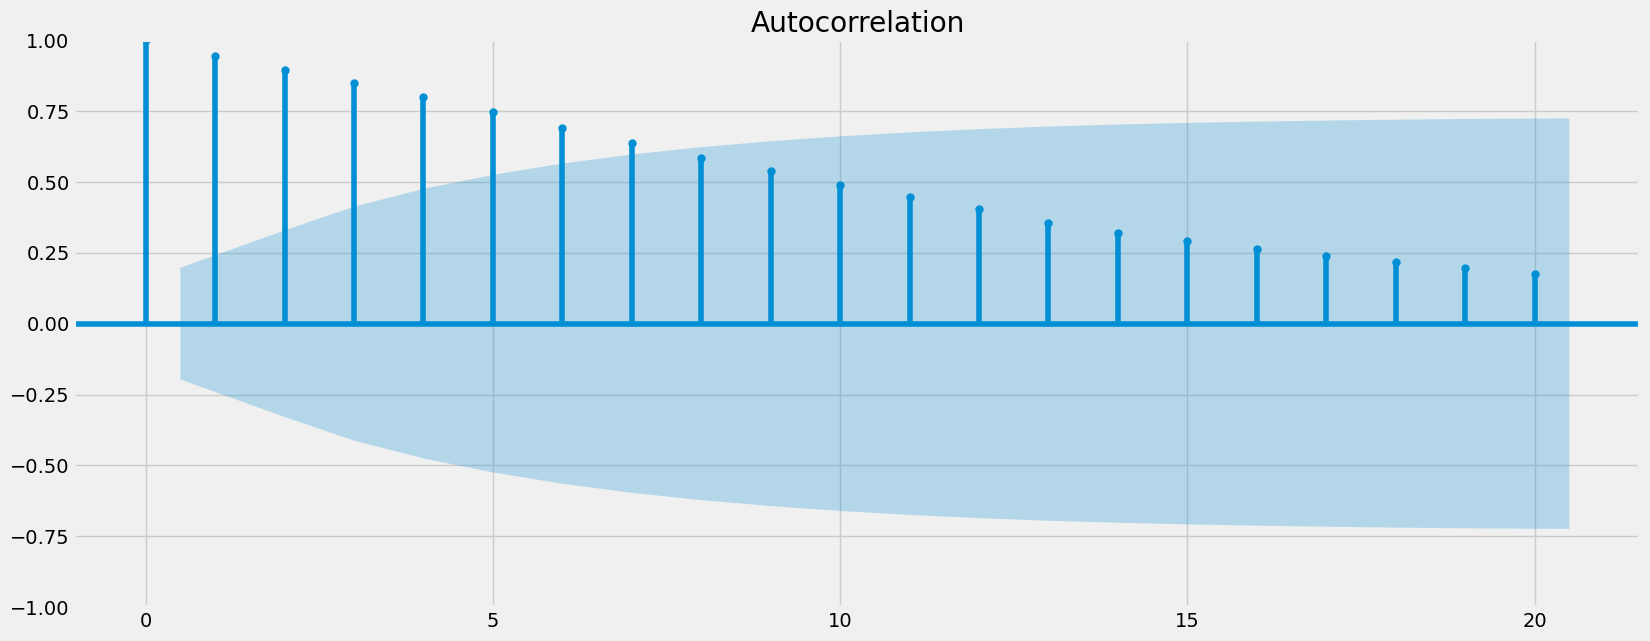

In [26]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### Observation
Since the many lines go above the blue edge of the confidence interval, we can assume that the are significantly correlated with each other and we also can assume by the number of lags that go beyond the confidence interval that the data is non-stationary.


### 5. Stationarizing Data

In [35]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [36]:
data_diff.dropna(inplace = True)

In [37]:
data_diff.head()

,Value
datetime,
2015-02-28,0.63
2015-03-31,1.12
2015-04-30,0.24
2015-05-31,0.22
2015-06-30,-0.01


In [38]:
data_diff.columns

Index(['Value'], dtype='object')

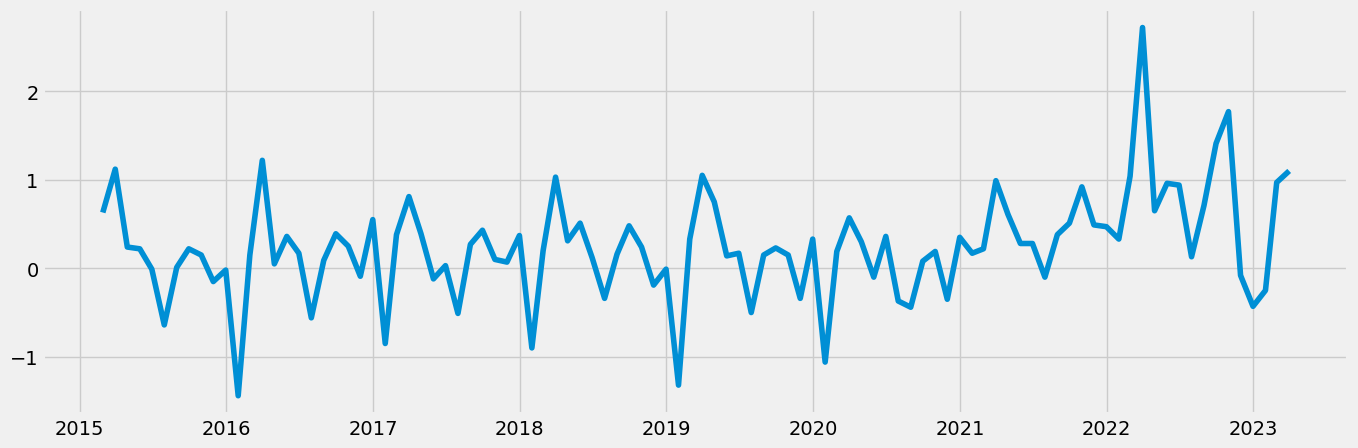

In [39]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [40]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.258961
p-value                         0.647732
Number of Lags Used            12.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


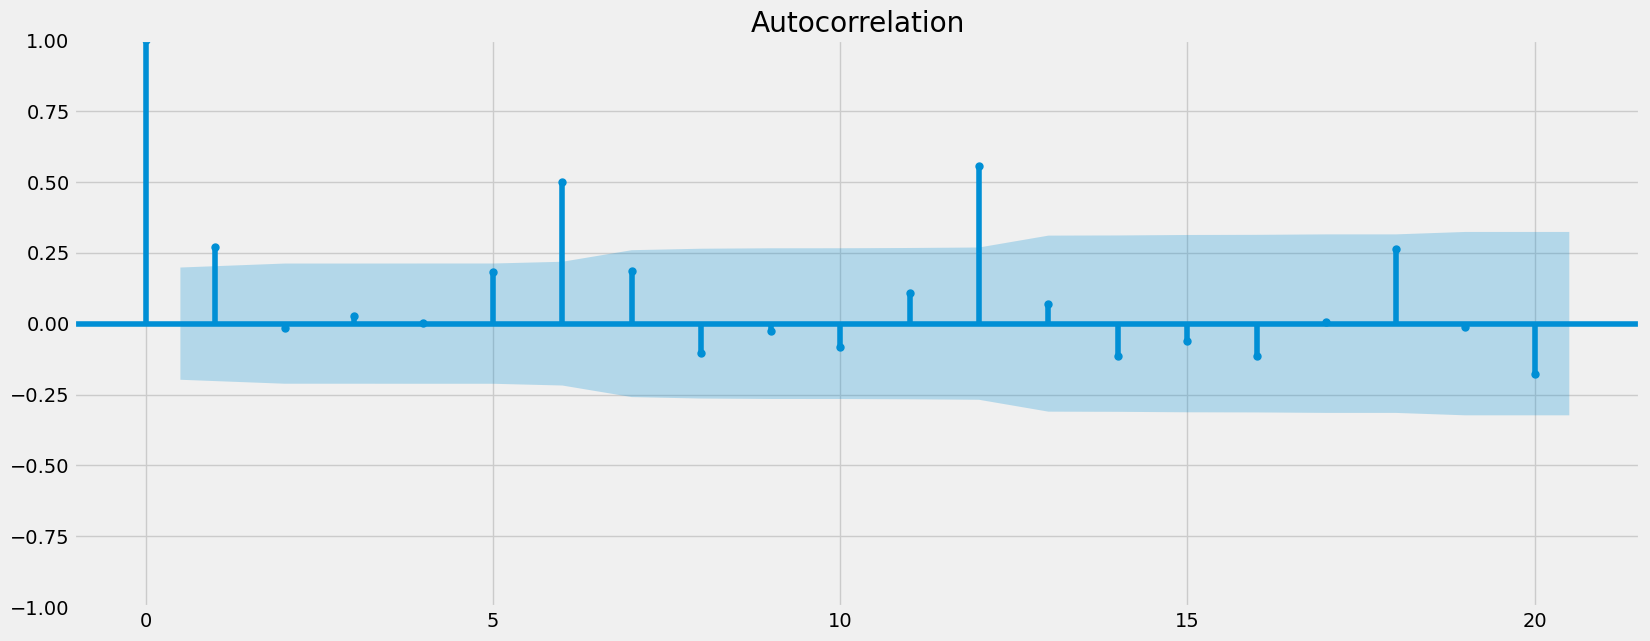

In [41]:
plot_acf(data_diff)
plt.show()

#### Obersevation
After the first round of stationarizing the data, the data are still non-stationary, because the Dickey Fuller test shows us that our test-statistic (-1.2) is still larger than our critical value (-2.89). Therefore, we need to perform a second round of stationarizing. 

### Second Round: Stationarizing Data

In [42]:
data_diff_2 = data_diff - data_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [43]:
data_diff_2.dropna(inplace = True)

In [44]:
data_diff_2.head()

,Value
datetime,
2015-03-31,0.49
2015-04-30,-0.88
2015-05-31,-0.02
2015-06-30,-0.23
2015-07-31,-0.63


In [46]:
data_diff_2.columns

Index(['Value'], dtype='object')

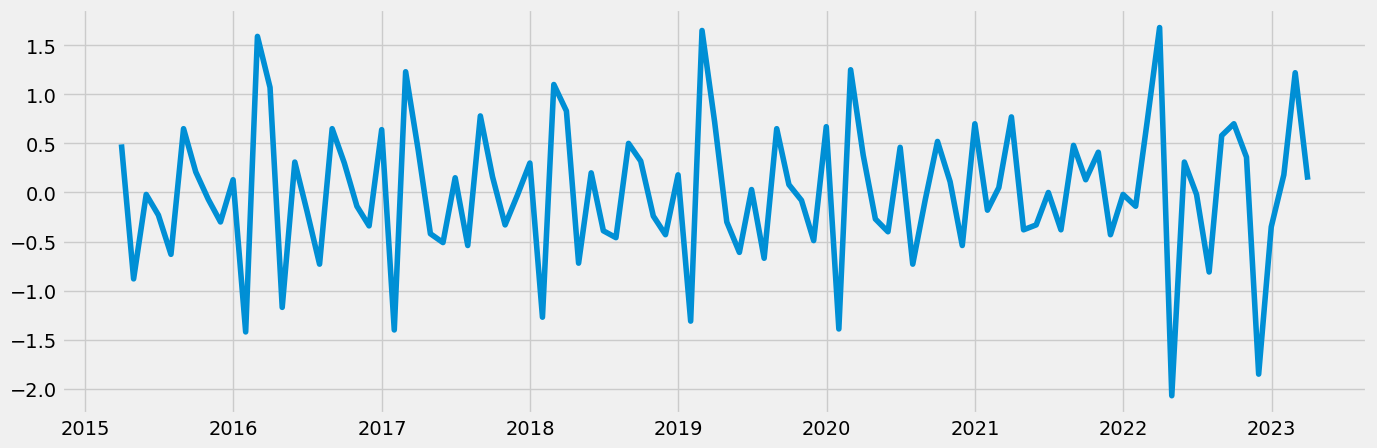

In [47]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [48]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.774582
p-value                         0.003178
Number of Lags Used            11.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


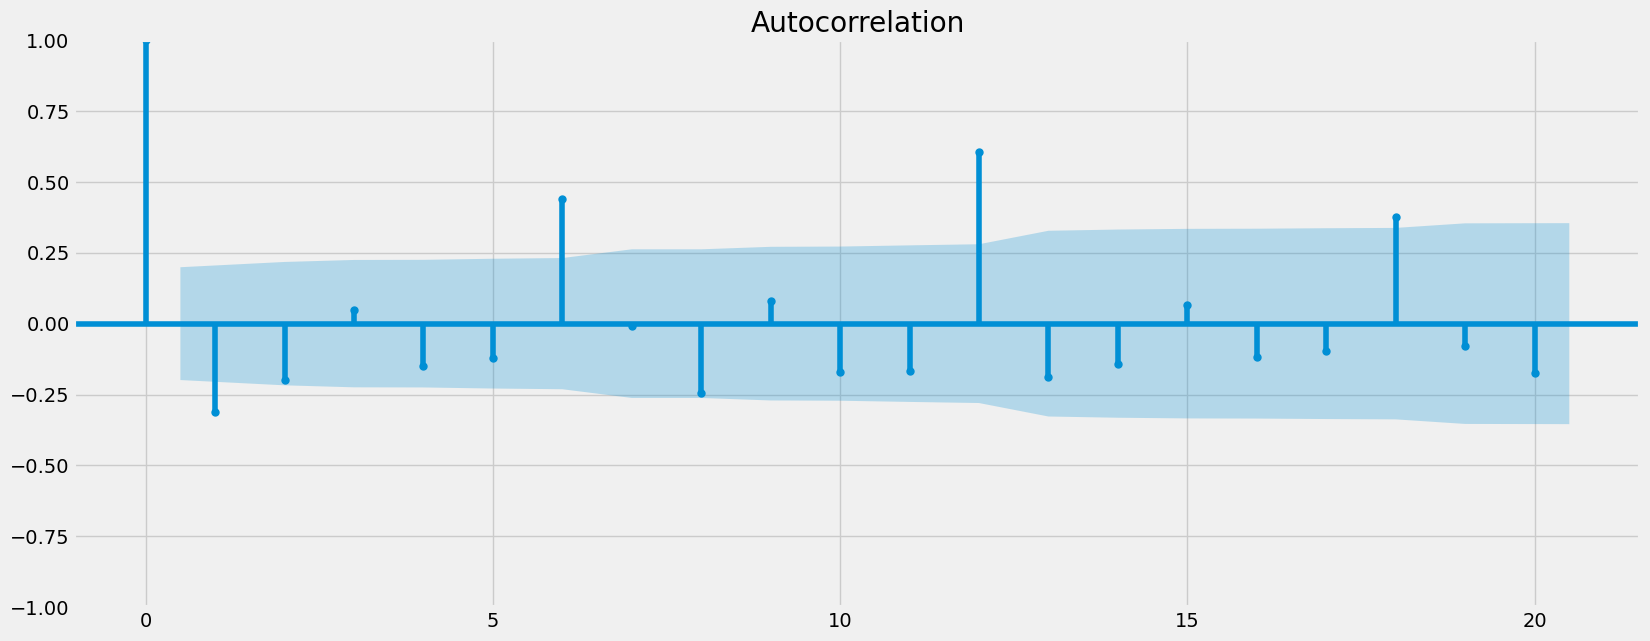

In [49]:
plot_acf(data_diff_2)
plt.show()

#### Obersevation
After the second round of stationarizing the data we now have stationary data according to the Dickey Fuller test that shows us that our critical value (-3.7) is now smaller than our test statitic (-2.89). However it is important to note that we still have some autocorrelation therefore we have a weakish stationarity.